In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from matplotlib.ticker import FormatStrFormatter

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, get_exact_p, get_fdr_p_df

In [4]:
train_test_str = 'train_test'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs


In [8]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall psychopathology','Psychosis (positive)','Psychosis (negative)','Anxious-misery','Externalizing','Fear']

print(phenos)

metrics = ['ct', 'vol']
metrics_label = ['Thickness', 'Volume']

algs = ['rr',]
scores = ['corr', 'rmse', 'mae']
seeds = np.arange(0,100)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear']


In [9]:
num_algs = len(algs)
num_metrics = len(metrics)
num_phenos = len(phenos)
num_scores = len(scores)

## Setup plots

In [10]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 0.8)
cmap = my_get_cmap('psych_phenos')

## Load data

In [11]:
def load_data(indir, phenos, alg, score, metric):

    accuracy_mean = np.zeros((100, len(phenos)))
    accuracy_std = np.zeros((100, len(phenos)))
    y_pred_var = np.zeros((100, len(phenos)))
    p_vals = pd.DataFrame(columns = phenos)
    sig_points = pd.DataFrame(columns = phenos)

    for p, pheno in enumerate(phenos):
        accuracy_mean[:,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean.txt'))
        accuracy_std[:,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_std.txt'))

        y_pred_out_repeats = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'y_pred_out_repeats.txt'))
        y_pred_var[:,p] = y_pred_out_repeats.var(axis = 0)

        in_file = os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'permuted_acc.txt')
        if os.path.isfile(in_file):
            permuted_acc = np.loadtxt(in_file)
            acc = np.mean(accuracy_mean[:,p])
            p_vals.loc[metric,pheno] = np.sum(permuted_acc >= acc) / len(permuted_acc)
            sig_points.loc[metric,pheno] = np.percentile(permuted_acc,95)

#     if score == 'rmse' or score == 'mae':
#         accuracy_mean = np.abs(accuracy_mean)
#         accuracy_std = np.abs(accuracy_std)

    return accuracy_mean, accuracy_std, y_pred_var, p_vals, sig_points

In [12]:
s = 0; score = scores[s]; print(score)
a = 0; alg = algs[a]; print(alg)
m = 1; metric = metrics[m]; print(metric)

corr
rr
vol


In [13]:
covs = ['ageAtScan1_Years', 'sex_adj']
# covs = ['ageAtScan1_Years', 'sex_adj', 'medu1']

# predictiondir = os.path.join(os.environ['PIPELINEDIR'], '8_prediction', 'out', outfile_prefix)
predictiondir = os.path.join(os.environ['PIPELINEDIR'], '8_prediction_fixedpcs', 'out', outfile_prefix)
print(predictiondir)

modeldir = predictiondir+'predict_symptoms_rcv_nuis_'+'_'.join(covs)
print(modeldir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline/8_prediction_fixedpcs/out/t1Exclude_schaefer_400_
/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline/8_prediction_fixedpcs/out/t1Exclude_schaefer_400_predict_symptoms_rcv_nuis_ageAtScan1_Years_sex_adj


## Load whole-brain results

In [14]:
accuracy_mean, accuracy_std, _, p_vals, sig_points = load_data(modeldir, phenos, alg, score, metric)
p_vals = get_fdr_p_df(p_vals)
p_vals[p_vals < 0.05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
vol,0.0374,0.02094,NaN,NaN,NaN,0.02094


In [15]:
accuracy_mean_z, accuracy_std_z, _, p_vals_z, sig_points_z = load_data(modeldir+'_z', phenos, alg, score, metric)
p_vals_z = get_fdr_p_df(p_vals_z)
p_vals_z[p_vals_z < 0.05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
vol,0.01167,0.01167,NaN,NaN,NaN,0.012


### Plot

In [16]:
stats = pd.DataFrame(index = phenos, columns = ['meanx', 'meany', 'test_stat', 'pval'])
for i, pheno in enumerate(phenos): 

    df = pd.DataFrame(columns = ['model','pheno'])
    for model in ['wb','wbz']:
        df_tmp = pd.DataFrame(columns = df.columns)
        if model == 'wb':
            df_tmp.loc[:,'score'] = accuracy_mean[:,i]
        elif model == 'wbz':
            df_tmp.loc[:,'score'] = accuracy_mean_z[:,i]
        df_tmp.loc[:,'pheno'] = pheno
        df_tmp.loc[:,'model'] = model

        df = pd.concat((df, df_tmp), axis = 0)
    
    x = df.loc[df.loc[:,'model'] == 'wb','score']
    y = df.loc[df.loc[:,'model'] == 'wbz','score']
    stats.loc[pheno,'meanx'] = np.round(np.mean(x),3)
    stats.loc[pheno,'meany'] = np.round(np.mean(y),3)
    stats.loc[pheno,'test_stat'] = stats.loc[pheno,'meanx']-stats.loc[pheno,'meany']
    stats.loc[pheno,'pval'] = get_exact_p(x, y)
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

stats

,meanx,meany,test_stat,pval,pval_corr,sig
Overall_Psychopathology,0.082,0.108,-0.026,0,0,True
Psychosis_Positive,0.1,0.103,-0.003,0.14,0.21,False
Psychosis_NegativeDisorg,-0.009,0.01,-0.019,0.03,0.06,False
AnxiousMisery,-0.006,-0.006,0,0.46,0.46,False
Externalizing,0.04,0.057,-0.017,0,0,True
Fear,0.095,0.097,-0.002,0.34,0.408,False


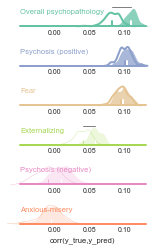

In [17]:
sig_points_plot = (sig_points + sig_points_z)/2
idx = np.argsort(accuracy_mean_z.mean(axis = 0))[::-1][:]
if metric == 'ct':
    idx = np.array([5, 1, 0, 3, 4, 2])
elif metric == 'vol':
    idx = np.array([0, 1, 5, 4, 2, 3])

f, ax = plt.subplots(len(phenos),1)
f.set_figwidth(2.25)
f.set_figheight(4)

# for i, pheno in enumerate(phenos):
for i, ii in enumerate(idx):
    pheno = phenos[ii]
    for model in ['wb','wbz']:
#         ax[i].axvline(x=sig_points_plot.values.mean(), ymax=1.2, clip_on=False, color='gray', alpha=0.5, linestyle='--', linewidth=1.5)
#         if i == 0:
#             ax[i].text(sig_points_plot.values.mean(), 40, '$p$ < 0.05', fontweight="regular", color='gray',
#                     ha="left", va="center", rotation=270)

        if model == 'wb':
            if p_vals.loc[:,pheno].values[0]<.05:
                sns.kdeplot(x=accuracy_mean[:,ii], ax=ax[i], bw_adjust=.75, clip_on=False, color=cmap[ii], alpha=0.5, linewidth=2)
                # add point estimate
                ax[i].axvline(x=accuracy_mean[:,ii].mean(), ymax=0.25, clip_on=False, color=cmap[ii], linewidth=2)
            else:
                sns.kdeplot(x=accuracy_mean[:,ii], ax=ax[i], bw_adjust=.75, clip_on=False, color=cmap[ii], linewidth=.25)
                # add point estimate
                ax[i].axvline(x=accuracy_mean[:,ii].mean(), ymax=0.25, clip_on=False, color=cmap[ii], linewidth=0.5)
            
#             ax[i].axvline(x=sig_points.loc[:,pheno].values[0], ymax=1, clip_on=False, color='gray', alpha=0.5, linestyle='--', linewidth=1.5)
        elif model == 'wbz':
            if p_vals_z.loc[:,pheno].values[0]<.05:
                sns.kdeplot(x=accuracy_mean_z[:,ii], ax=ax[i], bw_adjust=.75, clip_on=False, color=cmap[ii], alpha=0.75, linewidth=0, fill=True)
#                 sns.kdeplot(x=accuracy_mean_z[:,ii], ax=ax[i], bw_adjust=.75, clip_on=False, color="w", alpha=1, linewidth=1)
                # add point estimate
                ax[i].axvline(x=accuracy_mean_z[:,ii].mean(), ymax=0.25, clip_on=False, color='w', linewidth=2)
            else:
                sns.kdeplot(x=accuracy_mean_z[:,ii], ax=ax[i], bw_adjust=.75, clip_on=False, color=cmap[ii], alpha=0.2, linewidth=0, fill=True)
#                 sns.kdeplot(x=accuracy_mean_z[:,ii], ax=ax[i], bw_adjust=.75, clip_on=False, color="w", alpha=1, linewidth=1)
                # add point estimate
                ax[i].axvline(x=accuracy_mean_z[:,ii].mean(), ymax=0.25, clip_on=False, color='w', linewidth=1)
#             ax[i].axvline(x=sig_points_z.loc[:,pheno].values[0], ymax=1, clip_on=False, color='gray', alpha=0.5, linestyle='--', linewidth=1.5)
#             ax[i].text(sig_points_z.loc[:,pheno].values[0], 40, '$p$<.05', fontweight="regular", color='gray',
#                        ha="left", va="bottom", rotation=270)

    # note between model significant performance difference
    if stats.loc[pheno,'sig']:
        ax[i].plot([accuracy_mean[:,ii].mean(),accuracy_mean_z[:,ii].mean()],[ax[i].get_ylim()[1],ax[i].get_ylim()[1]], color='gray', linewidth=1)
#         ax[i].text(accuracy_mean[:,ii].mean()+[accuracy_mean_z[:,ii].mean()-accuracy_mean[:,ii].mean()],
#                    ax[i].get_ylim()[1], '$p$<.05', fontweight="regular", color='gray', ha="left", va="center")
#         ax[i].axvline(x=accuracy_mean[:,ii].mean(), ymin=ax[i].get_ylim()[1], clip_on=False, color='gray', linewidth=1)
#         ax[i].axvline(x=accuracy_mean_z[:,ii].mean(), ymin=ax[i].get_ylim()[1], clip_on=False, color='gray', linewidth=1)
#         ax[i].axhline(y=25, linewidth=2, xmin=accuracy_mean[:,ii].mean(), xmax=accuracy_mean_z[:,ii].mean(), color = 'gray')
#         ax[i].axhline(y=25, linewidth=2, color = 'black')

    if score == 'corr':
        ax[i].set_xlim([accuracy_mean_z.min(),
                        accuracy_mean_z.max()])

    ax[i].axhline(y=0, linewidth=2, clip_on=False, color=cmap[ii])

    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
#     if score == 'corr':
#         if i != len(idx)-1:
#             ax[i].set_xticklabels([])

    if i == len(idx)-1:
        if score == 'corr': ax[i].set_xlabel('corr(y_true,y_pred)')
        elif score == 'rmse': ax[i].set_xlabel('neg[RMSE] (higher = better)')
        elif score == 'mae': ax[i].set_xlabel('neg[MAE] (higher = better)')

    ax[i].tick_params(pad = -2)

    if score == 'corr':
        ax[i].text(0, 0.75, phenos_label[ii], fontweight="regular", color=cmap[ii],
                ha="left", va="center", transform=ax[i].transAxes)

f.subplots_adjust(hspace=1)
# f.suptitle(alg+'_'+score+'_'+metric+' | '+'_'.join(covs))
f.savefig(outfile_prefix+'performance_comparison_'+alg+'_'+score+'_'+metric+'.svg', dpi = 600, bbox_inches = 'tight')